modelos a comparar: 

# vamos a probar los 5 (excepto el LSTM, ese solo para suavizado vs no suavizado) para: datos suavizados, FPLS, FPCA, 
(esto obviamente seria imposible si tuviera muchos datos)

LSTM con masking
Dense NN
Medida de profundidad
Knn?
XGBOOST

pasos:
1- Definir funcion que te entrene los 5 modelos y te cree las comparaciones (roc, validacion, etc)
2- Correrlo en cada caso


In [ ]:
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch
from skfda.preprocessing.smoothing.validation import  LinearSmootherGeneralizedCVScorer
from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother

# Defining grid search
bandwidth = np.linspace(0.01, 1, 100)


# Nadaraya-Watson kernel smoother
nw = SmoothingParameterSearch(
    KernelSmoother(kernel_estimator=NadarayaWatsonHatMatrix()),
    bandwidth,
    scoring=LinearSmootherGeneralizedCVScorer(penalization_function=lambda t:1),
    param_name='kernel_estimator__bandwidth'
)


nw.fit(X_func)
x_opt = nw.transform(X_func)

In [90]:
from sklearn.model_selection import train_test_split
import numpy as np
import skfda

X = np.load('X.npy')
y = np.load('y.npy')

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X/15, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42
)




In [91]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


# 1. Instantiate the classifier with some reasonable defaults
xgb_clf = xgb.XGBClassifier(
   # L2 regularization
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss' # or 'auc'
)

# 2. Fit with early stopping on the validation set
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# 3. Predictions on test set
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)[:,1]

# 4. Evaluation
acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC:      {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

[0]	validation_0-logloss:0.44686
[1]	validation_0-logloss:0.41426
[2]	validation_0-logloss:0.39751
[3]	validation_0-logloss:0.38706
[4]	validation_0-logloss:0.37934
[5]	validation_0-logloss:0.37470
[6]	validation_0-logloss:0.37260


c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:01:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[7]	validation_0-logloss:0.36918
[8]	validation_0-logloss:0.36958
[9]	validation_0-logloss:0.36984
[10]	validation_0-logloss:0.37013
[11]	validation_0-logloss:0.37019
[12]	validation_0-logloss:0.36884
[13]	validation_0-logloss:0.36729
[14]	validation_0-logloss:0.36871
[15]	validation_0-logloss:0.36805
[16]	validation_0-logloss:0.36731
[17]	validation_0-logloss:0.36601
[18]	validation_0-logloss:0.36458
[19]	validation_0-logloss:0.36513
[20]	validation_0-logloss:0.36568
[21]	validation_0-logloss:0.36616
[22]	validation_0-logloss:0.36531
[23]	validation_0-logloss:0.36509
[24]	validation_0-logloss:0.36303
[25]	validation_0-logloss:0.36323
[26]	validation_0-logloss:0.36250
[27]	validation_0-logloss:0.36272
[28]	validation_0-logloss:0.36340
[29]	validation_0-logloss:0.36145
[30]	validation_0-logloss:0.36083
[31]	validation_0-logloss:0.36075
[32]	validation_0-logloss:0.36148
[33]	validation_0-logloss:0.36215
[34]	validation_0-logloss:0.36112
[35]	validation_0-logloss:0.36125
[36]	validation_0

In [143]:
np.newaxis(evals)

TypeError: 'NoneType' object is not callable

In [ ]:
evals = evals[:, np.newaxis]

In [145]:
evals[:, np.newaxis].shape

(150, 1)

In [147]:
# ideamos una partida imaginaria con cheating

first_20 = np.linspace(0, -5, 20)
next_30 = np.linspace(-5, 15, 30)
last_100 = np.linspace(15, 15, 100)
evals = np.concatenate([first_20, next_30, last_100])
prob = xgb_clf.predict_proba(evals[:, np.newaxis].T)
print("Probabilities for cheating evals:")
print(prob[:, 1])  # Probabilities of being in class 1

Probabilities for cheating evals:
[0.88916534]


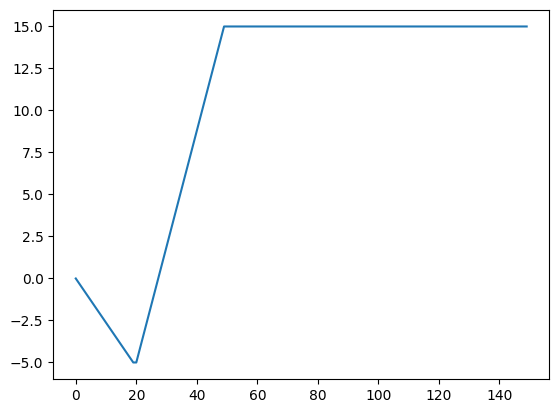

In [148]:
plt.plot(evals)

In [ ]:
import numpy as np
from scipy.optimize import minimize


# Objective function: negative cheating prob because we minimize
def objective(x):
    x = np.clip(x, -15, 15)  # Optional: constrain values
    prob = xgb_clf.predict_proba([x])[0][1]  # Cheating class prob
    avg_diff = np.mean(np.abs(np.diff(x)))  # Average difference between consecutive elements
    return -prob  # We want to maximize prob → minimize -prob

# Initial input
max_len = 150
initial_input = np.concatenate((np.asarray([0]*20), np.random.uniform(-15, 15, size=max_len-20)))

# Run optimization
result = minimize(objective, initial_input, method='L-BFGS-B', bounds=[(-15, 15)] * max_len)

# Best input found
optimized_input = result.x
max_cheating_prob = -result.fun

print("Most cheating game input:", optimized_input)
print("Cheating probability:", max_cheating_prob)


Most cheating game input: [ 5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.          5.          5.
  5.          5.          5.          5.         14.59864658  5.
  5.         14.64279373  5.          5.31679274 12.63442355  5.
 13.29831875 14.75183743  5.          5.          6.18804816  7.85822317
  5.          5.         11.39917125  5.          5.          5.
  5.          5.          9.58206083  5.         14.22055633 10.14742676
 13.14790197 11.96596881  7.19597394  5.          5.          5.
 14.03606246  5.3466817   5.         14.961594    9.41202247  5.
  5.          5.          5.          5.          5.          8.09887846
  5.          5.          5.          5.         10.15225437  5.
  5.          5.          5.          5.         13.26014346  9.63350714
  5.         14.27967348 10.14497361  5.          5.         10.44560435
  5.          5.        

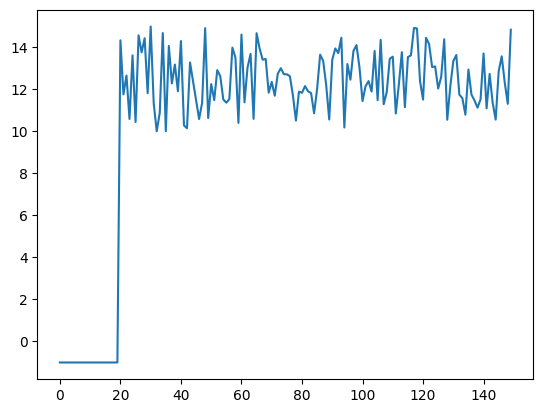

In [127]:
plt.plot(optimized_input)

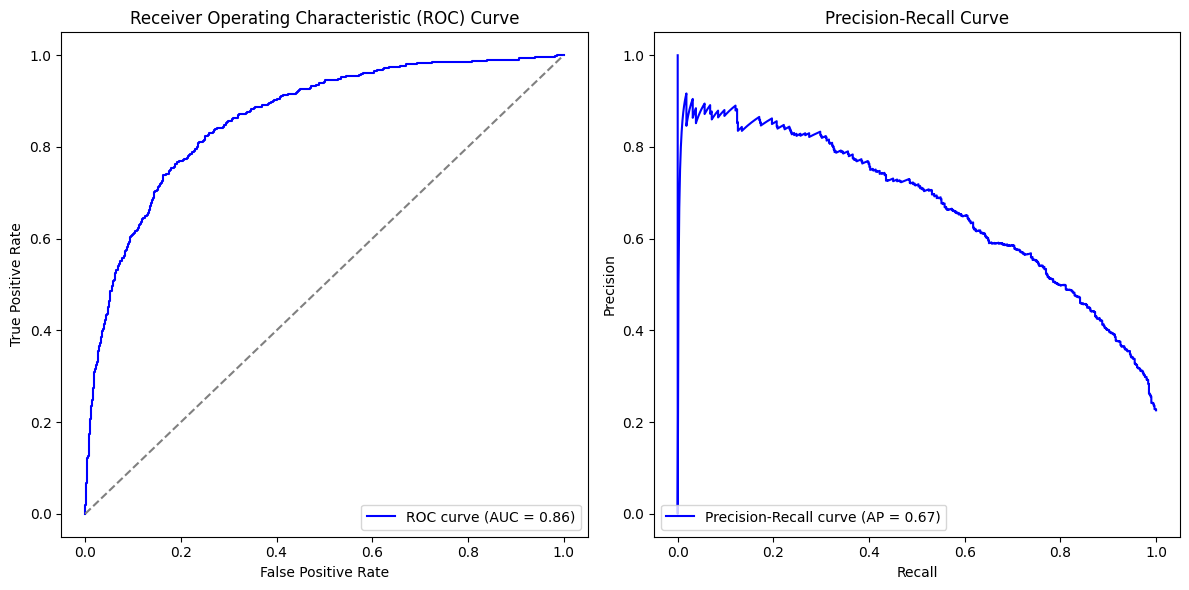

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


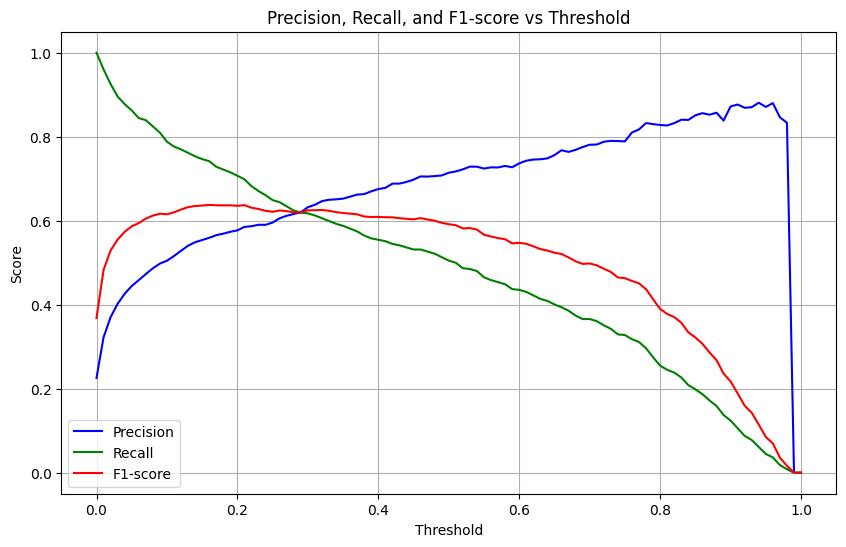

In [20]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = y_prob

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [128]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
max_len = 150
# Define the inverse model
inverse_model = tf.keras.Sequential([
    layers.Input(shape=(max_len,)),  # Input shape matches the input to the classification model
    layers.Dense(64, activation='relu'),
    layers.Dense(max_len, activation='relu')  # Output shape matches the input shape
])
# Define a custom loss function to maximize the cheating probability
def custom_loss(y_true, y_pred):
    cheating_prob = xgb_clf.predict(y_pred)  # Get the cheating probability from the classification model
    # Also penalize the model for being close to zero, we want values that are far from zero
    return -tf.reduce_mean(cheating_prob) 


# Compile the inverse model
inverse_model.compile(optimizer='adam', loss=custom_loss)



# Generate random initial input for the inverse model
initial_input = np.random.uniform(-15, 15, size=(1, max_len)).astype('float32')

# Train the inverse model
inverse_model.fit(
    x=initial_input,
    y=np.zeros_like(initial_input),  # Dummy target, as the loss is custom
    epochs=50,
    batch_size=1,
    verbose=1
)

# Get the "most cheating" game
most_cheating_game = inverse_model.predict(initial_input)
print("Most cheating game:", most_cheating_game)

Epoch 1/50


NotImplementedError: Cannot convert a symbolic tf.Tensor (sequential_29_1/dense_65_1/Relu:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.

In [21]:
X_train = skfda.FDataGrid(X_train, grid_points=np.linspace(0, 1, 150))
X_val = skfda.FDataGrid(X_val, grid_points=np.linspace(0, 1, 150))
X_test = skfda.FDataGrid(X_test, grid_points=np.linspace(0, 1, 150))

In [22]:
y_test.sum()

np.int64(604)

In [23]:
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch
from skfda.preprocessing.smoothing.validation import  LinearSmootherGeneralizedCVScorer
from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother


    
bandwidth = np.linspace(0.01, 1, 150)


# Nadaraya-Watson kernel smoother
nw = SmoothingParameterSearch(
    KernelSmoother(kernel_estimator=NadarayaWatsonHatMatrix()),
    bandwidth,
    scoring=LinearSmootherGeneralizedCVScorer(penalization_function=lambda t:1),
    param_name='kernel_estimator__bandwidth'
)

nw.fit(X_train)
X_train_smooth = nw.transform(X_train)
X_val_smooth = nw.transform(X_val)
X_test_smooth = nw.transform(X_test)


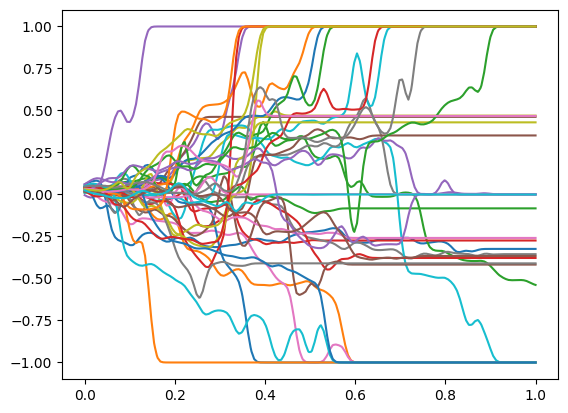

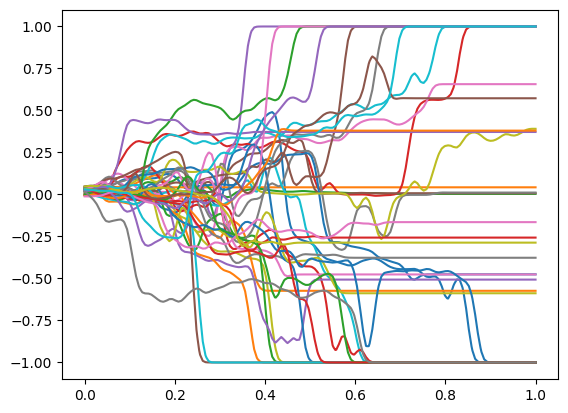

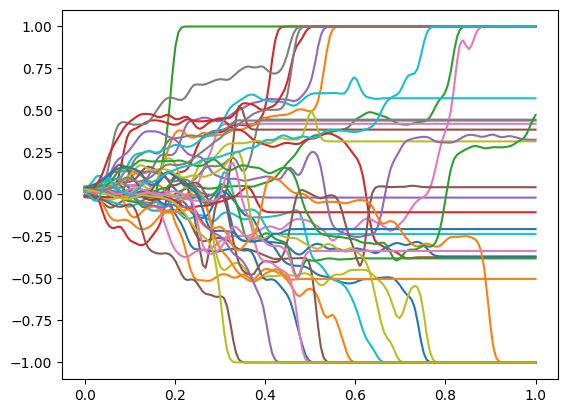

In [24]:
import matplotlib.pyplot as plt
X_val_smooth[:40].plot()
X_test_smooth[:40].plot()
X_train_smooth[:40].plot()
plt.show()

In [25]:
import skfda.ml.classification as sc
from sklearn.metrics import classification_report

neigh = sc.KNeighborsClassifier()
neigh.fit(X_train_smooth, y_train)
y_pred_knn = neigh.predict(X_test_smooth)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

       False       0.85      0.87      0.86      2072
        True       0.51      0.49      0.50       604

    accuracy                           0.78      2676
   macro avg       0.68      0.68      0.68      2676
weighted avg       0.78      0.78      0.78      2676



In [26]:
neigh = sc.NearestCentroid()
neigh.fit(X_train_smooth, y_train)
y_pred_knn = neigh.predict(X_test_smooth)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

       False       0.92      0.65      0.76      2072
        True       0.41      0.81      0.54       604

    accuracy                           0.69      2676
   macro avg       0.66      0.73      0.65      2676
weighted avg       0.81      0.69      0.71      2676



In [27]:
neigh = sc.MaximumDepthClassifier()
neigh.fit(X_train_smooth, y_train)
y_pred_knn = neigh.predict(X_test_smooth)
print(classification_report(y_test, y_pred_knn))

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\skfda\preprocessing\feature_construction\_per_class_transformer.py:212: UserWarning: Parameter 'transformer' with type <class 'skfda.exploratory.depth._depth.ModifiedBandDepth'> should use the data for  fitting.It should have the 'stateless' tag set to 'False'
  warnings.warn(


              precision    recall  f1-score   support

       False       0.91      0.73      0.81      2072
        True       0.44      0.75      0.56       604

    accuracy                           0.73      2676
   macro avg       0.67      0.74      0.68      2676
weighted avg       0.80      0.73      0.75      2676



In [28]:
neigh = sc.LogisticRegression(max_features=10)
neigh.fit(X_train_smooth, y_train)
y_pred_knn = neigh.predict(X_test_smooth)
print(classification_report(y_test, y_pred_knn))

KeyboardInterrupt: 

In [69]:
import tensorflow as tf

In [29]:
from skfda.preprocessing.dim_reduction import FPCA
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
n = 20
pca = FPCA(n_components=n)
X_train_pca = pca.fit_transform(X_train_smooth)
X_test_pca = pca.transform(X_test_smooth)
X_val_pca = pca.transform(X_val_smooth)

# Define the neural network model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(n,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pca, y_train, epochs=50, batch_size=32, validation_data=(X_val_pca, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pca, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7931 - loss: 0.5163 - val_accuracy: 0.7948 - val_loss: 0.3964
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7944 - loss: 0.4084 - val_accuracy: 0.8087 - val_loss: 0.3905
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8032 - loss: 0.3976 - val_accuracy: 0.8132 - val_loss: 0.3871
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7996 - loss: 0.4057 - val_accuracy: 0.8158 - val_loss: 0.3846
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8023 - loss: 0.4099 - val_accuracy: 0.8191 - val_loss: 0.3833
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8144 - loss: 0.3960 - val_accuracy: 0.8154 - val_loss: 0.3828
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8087 - loss: 0.3968 - val_accuracy: 0.8132 - val_loss: 0.3844
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8095 - loss: 0.3873 - val_accuracy: 0.

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


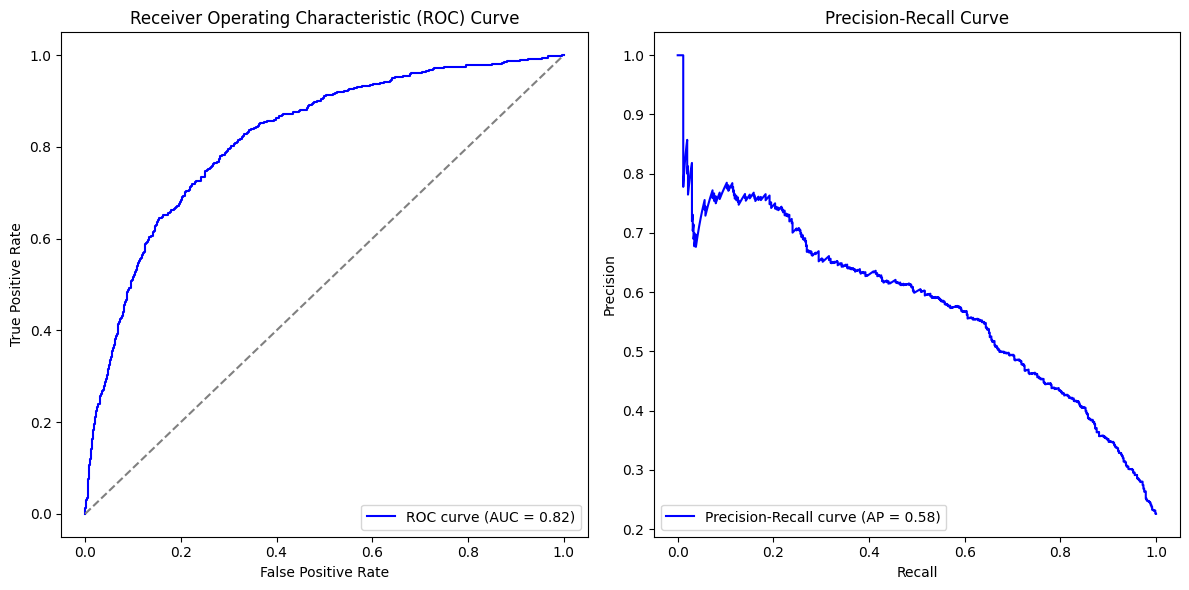

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

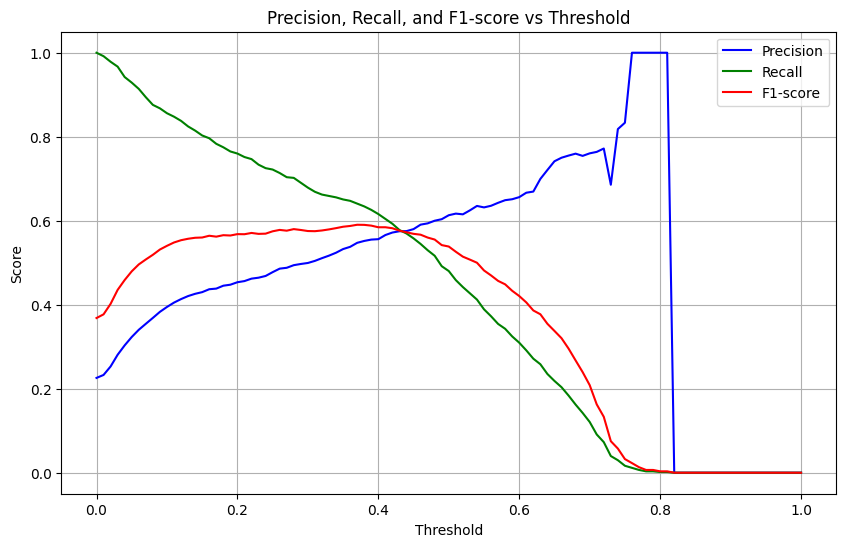

In [31]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test_pca)

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
n = 30
pca = FPCA(n_components=n)
X_train_pca = pca.fit_transform(X_train_smooth)
X_test_pca = pca.transform(X_test_smooth)
X_val_pca = pca.transform(X_val_smooth)

# 1. Instantiate the classifier with some reasonable defaults
xgb_clf = xgb.XGBClassifier(
   # L2 regularization
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss' # or 'auc'
)

# 2. Fit with early stopping on the validation set
xgb_clf.fit(
    X_train_pca, y_train,
    eval_set=[(X_val_pca, y_val)],
    verbose=True
)

# 3. Predictions on test set
y_pred = xgb_clf.predict(X_test_pca)
y_prob = xgb_clf.predict_proba(X_test_pca)[:,1]

# 4. Evaluation
acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC:      {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

[0]	validation_0-logloss:0.45776
[1]	validation_0-logloss:0.43120
[2]	validation_0-logloss:0.41324
[3]	validation_0-logloss:0.40200
[4]	validation_0-logloss:0.39631
[5]	validation_0-logloss:0.39291
[6]	validation_0-logloss:0.38802
[7]	validation_0-logloss:0.38634
[8]	validation_0-logloss:0.38497
[9]	validation_0-logloss:0.38523
[10]	validation_0-logloss:0.38371
[11]	validation_0-logloss:0.38346
[12]	validation_0-logloss:0.38359
[13]	validation_0-logloss:0.38270
[14]	validation_0-logloss:0.38152
[15]	validation_0-logloss:0.38266
[16]	validation_0-logloss:0.38295
[17]	validation_0-logloss:0.38303
[18]	validation_0-logloss:0.38248
[19]	validation_0-logloss:0.38160
[20]	validation_0-logloss:0.38212
[21]	validation_0-logloss:0.38206
[22]	validation_0-logloss:0.38092
[23]	validation_0-logloss:0.38245
[24]	validation_0-logloss:0.38314
[25]	validation_0-logloss:0.38337
[26]	validation_0-logloss:0.38351


c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:28:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[27]	validation_0-logloss:0.38458
[28]	validation_0-logloss:0.38454
[29]	validation_0-logloss:0.38435
[30]	validation_0-logloss:0.38555
[31]	validation_0-logloss:0.38581
[32]	validation_0-logloss:0.38600
[33]	validation_0-logloss:0.38692
[34]	validation_0-logloss:0.38775
[35]	validation_0-logloss:0.38971
[36]	validation_0-logloss:0.39078
[37]	validation_0-logloss:0.39060
[38]	validation_0-logloss:0.39227
[39]	validation_0-logloss:0.39301
[40]	validation_0-logloss:0.39313
[41]	validation_0-logloss:0.39268
[42]	validation_0-logloss:0.39150
[43]	validation_0-logloss:0.39216
[44]	validation_0-logloss:0.39292
[45]	validation_0-logloss:0.39347
[46]	validation_0-logloss:0.39497
[47]	validation_0-logloss:0.39496
[48]	validation_0-logloss:0.39670
[49]	validation_0-logloss:0.39797
[50]	validation_0-logloss:0.40050
[51]	validation_0-logloss:0.40226
[52]	validation_0-logloss:0.40260
[53]	validation_0-logloss:0.40301
[54]	validation_0-logloss:0.40383
[55]	validation_0-logloss:0.40400
[56]	validatio

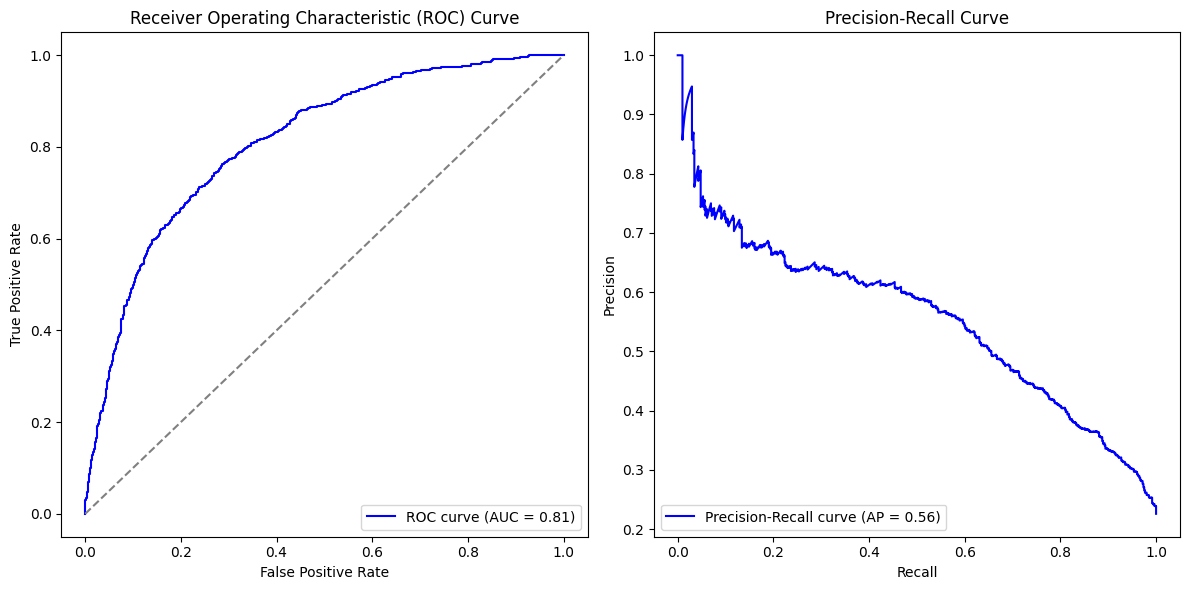

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


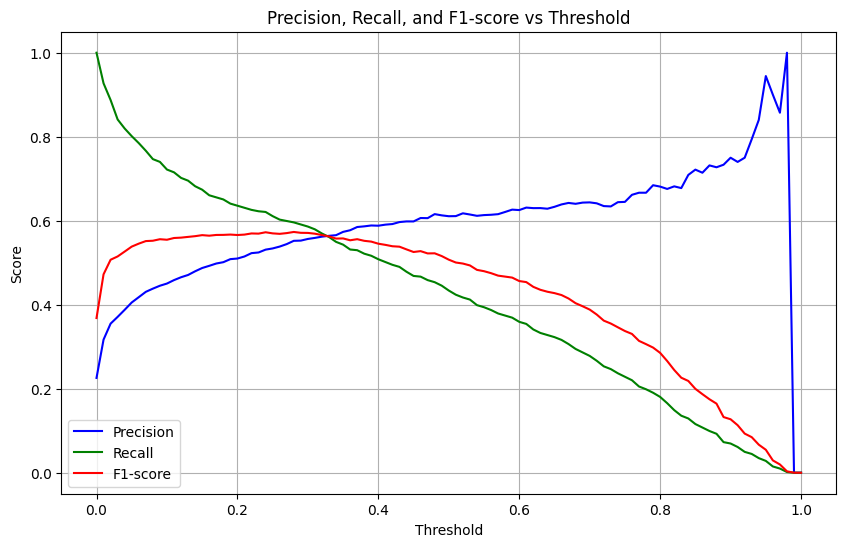

In [33]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob =y_prob

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
from skfda.preprocessing.dim_reduction import FPLS

pls = FPLS().fit(X_train_smooth, y_train)
X_train_pls = pls.transform(X_train_smooth)
X_test_pls = pls.transform(X_test_smooth)
X_val_pls = pls.transform(X_val_smooth)

# Define the neural network model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_pls.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pls, y_train, epochs=50, batch_size=32, validation_data=(X_val_pls, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pls, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50


c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7909 - loss: 0.5125 - val_accuracy: 0.7896 - val_loss: 0.4011
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7945 - loss: 0.4208 - val_accuracy: 0.7997 - val_loss: 0.4014
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7968 - loss: 0.4105 - val_accuracy: 0.7896 - val_loss: 0.4002
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7836 - loss: 0.4203 - val_accuracy: 0.7896 - val_loss: 0.4017
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7881 - loss: 0.4227 - val_accuracy: 0.7896 - val_loss: 0.4008
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7937 - loss: 0.4162 - val_accuracy: 0.7904 - val_loss: 0.4001
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7914 - loss: 0.4037 - val_accuracy: 0.7896 - val_loss: 0.4021
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7905 - loss: 0.4170 - val_accuracy: 0.7896 - val_

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


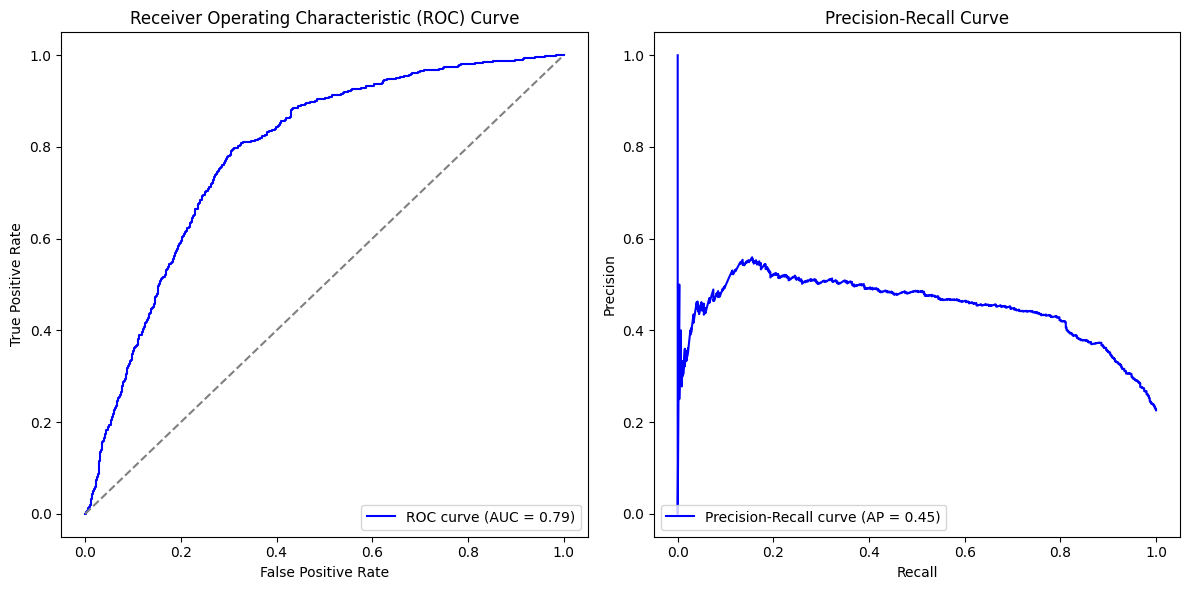

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

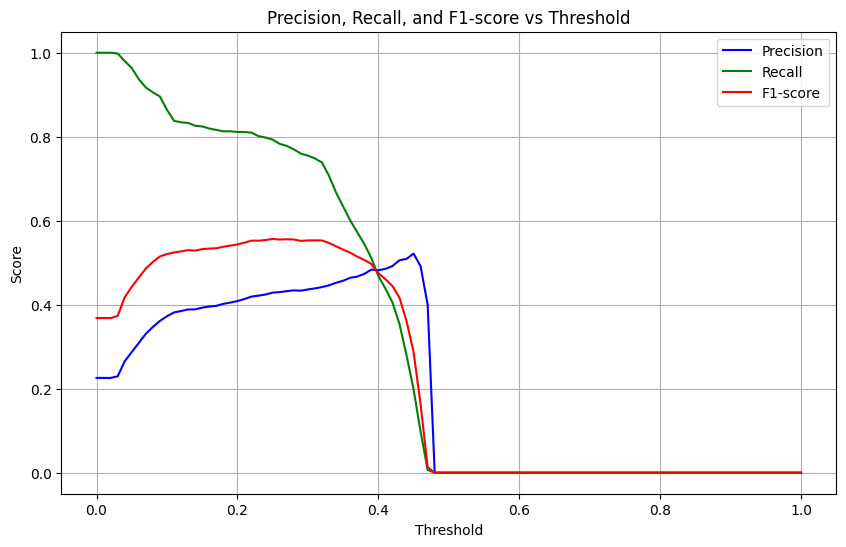

In [35]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test_pls)

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 1. Instantiate the classifier with some reasonable defaults
xgb_clf = xgb.XGBClassifier(
   # L2 regularization
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss' # or 'auc'
)

# 2. Fit with early stopping on the validation set
xgb_clf.fit(
    X_train_pls, y_train,
    eval_set=[(X_val_pls, y_val)],
    verbose=True
)

# 3. Predictions on test set
y_pred = xgb_clf.predict(X_test_pls)
y_prob = xgb_clf.predict_proba(X_test_pls)[:,1]

# 4. Evaluation
acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC:      {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

[0]	validation_0-logloss:0.46116
[1]	validation_0-logloss:0.43582
[2]	validation_0-logloss:0.42173
[3]	validation_0-logloss:0.41319
[4]	validation_0-logloss:0.40833
[5]	validation_0-logloss:0.40568
[6]	validation_0-logloss:0.40410
[7]	validation_0-logloss:0.40342
[8]	validation_0-logloss:0.40325
[9]	validation_0-logloss:0.40319
[10]	validation_0-logloss:0.40311
[11]	validation_0-logloss:0.40321
[12]	validation_0-logloss:0.40364
[13]	validation_0-logloss:0.40374
[14]	validation_0-logloss:0.40406
[15]	validation_0-logloss:0.40434
[16]	validation_0-logloss:0.40451
[17]	validation_0-logloss:0.40462
[18]	validation_0-logloss:0.40501
[19]	validation_0-logloss:0.40537
[20]	validation_0-logloss:0.40554
[21]	validation_0-logloss:0.40549
[22]	validation_0-logloss:0.40548
[23]	validation_0-logloss:0.40573
[24]	validation_0-logloss:0.40581
[25]	validation_0-logloss:0.40582
[26]	validation_0-logloss:0.40587
[27]	validation_0-logloss:0.40614
[28]	validation_0-logloss:0.40624
[29]	validation_0-loglos

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:29:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[73]	validation_0-logloss:0.40852
[74]	validation_0-logloss:0.40855
[75]	validation_0-logloss:0.40854
[76]	validation_0-logloss:0.40859
[77]	validation_0-logloss:0.40859
[78]	validation_0-logloss:0.40861
[79]	validation_0-logloss:0.40873
[80]	validation_0-logloss:0.40873
[81]	validation_0-logloss:0.40883
[82]	validation_0-logloss:0.40894
[83]	validation_0-logloss:0.40905
[84]	validation_0-logloss:0.40906
[85]	validation_0-logloss:0.40918
[86]	validation_0-logloss:0.40918
[87]	validation_0-logloss:0.40931
[88]	validation_0-logloss:0.40935
[89]	validation_0-logloss:0.40938
[90]	validation_0-logloss:0.40950
[91]	validation_0-logloss:0.40950
[92]	validation_0-logloss:0.40952
[93]	validation_0-logloss:0.40969
[94]	validation_0-logloss:0.40977
[95]	validation_0-logloss:0.40978
[96]	validation_0-logloss:0.40979
[97]	validation_0-logloss:0.40981
[98]	validation_0-logloss:0.40981
[99]	validation_0-logloss:0.40985
Test Accuracy: 0.7750
Test AUC:      0.7672

Classification Report:
              

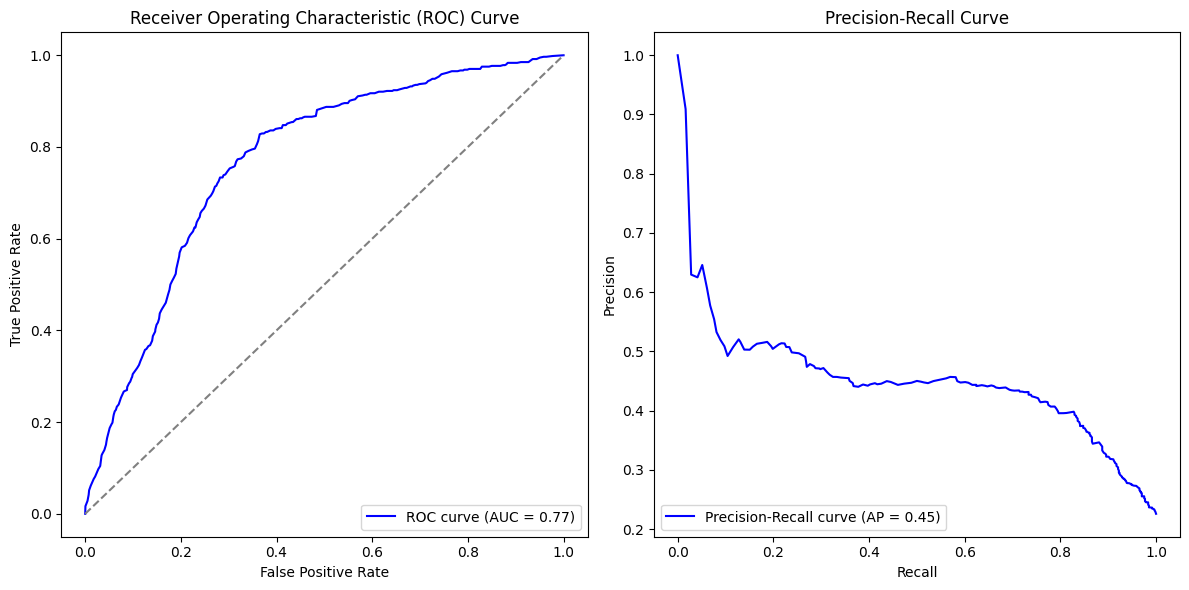

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

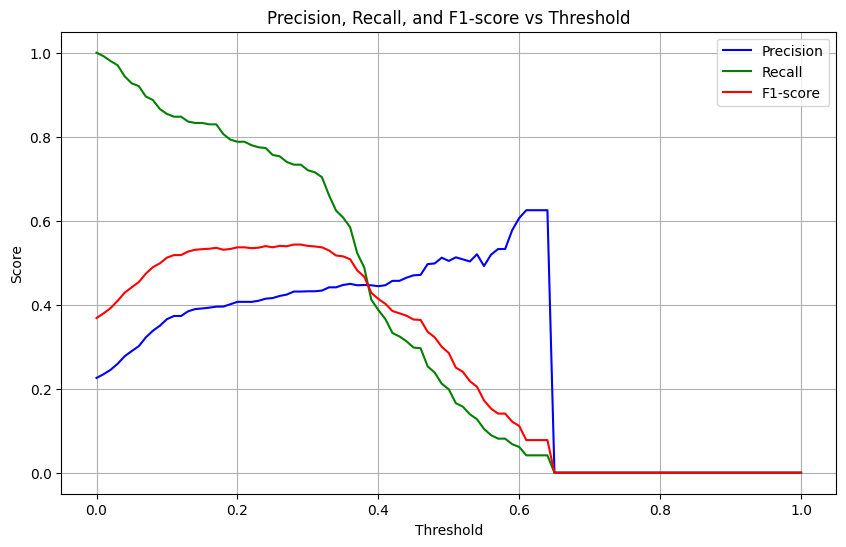

In [37]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = y_prob

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [264]:
X_val_smooth.data_matrix.shape

(2676, 150, 1)

In [38]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 1. Instantiate the classifier with some reasonable defaults
xgb_clf = xgb.XGBClassifier(
   # L2 regularization
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss', # or 'auc'
    n_estimators=200,
    scale_pos_weight= (len(y_train) - y_train.sum()) / y_train.sum(), # class imbalance
)

# 2. Fit with early stopping on the validation set
xgb_clf.fit(
    X_train_smooth.data_matrix[:,:,0], y_train,
    eval_set=[(X_val_smooth.data_matrix[:,:,0], y_val)],
    verbose=True
)

# 3. Predictions on test set
y_pred = xgb_clf.predict(X_test_smooth.data_matrix[:,:,0])
y_prob = xgb_clf.predict_proba(X_test_smooth.data_matrix[:,:,0])[:,1]

# 4. Evaluation
acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC:      {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

[0]	validation_0-logloss:0.59617
[1]	validation_0-logloss:0.54555
[2]	validation_0-logloss:0.51451
[3]	validation_0-logloss:0.49129
[4]	validation_0-logloss:0.47615
[5]	validation_0-logloss:0.46690
[6]	validation_0-logloss:0.46076


c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:29:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[7]	validation_0-logloss:0.45750
[8]	validation_0-logloss:0.45313
[9]	validation_0-logloss:0.45168
[10]	validation_0-logloss:0.44875
[11]	validation_0-logloss:0.44501
[12]	validation_0-logloss:0.44336
[13]	validation_0-logloss:0.43861
[14]	validation_0-logloss:0.43644
[15]	validation_0-logloss:0.43371
[16]	validation_0-logloss:0.43295
[17]	validation_0-logloss:0.42988
[18]	validation_0-logloss:0.42886
[19]	validation_0-logloss:0.42711
[20]	validation_0-logloss:0.42605
[21]	validation_0-logloss:0.42625
[22]	validation_0-logloss:0.42465
[23]	validation_0-logloss:0.42092
[24]	validation_0-logloss:0.41987
[25]	validation_0-logloss:0.41600
[26]	validation_0-logloss:0.41182
[27]	validation_0-logloss:0.40887
[28]	validation_0-logloss:0.40845
[29]	validation_0-logloss:0.40839
[30]	validation_0-logloss:0.40650
[31]	validation_0-logloss:0.40554
[32]	validation_0-logloss:0.40542
[33]	validation_0-logloss:0.40537
[34]	validation_0-logloss:0.40350
[35]	validation_0-logloss:0.40259
[36]	validation_0

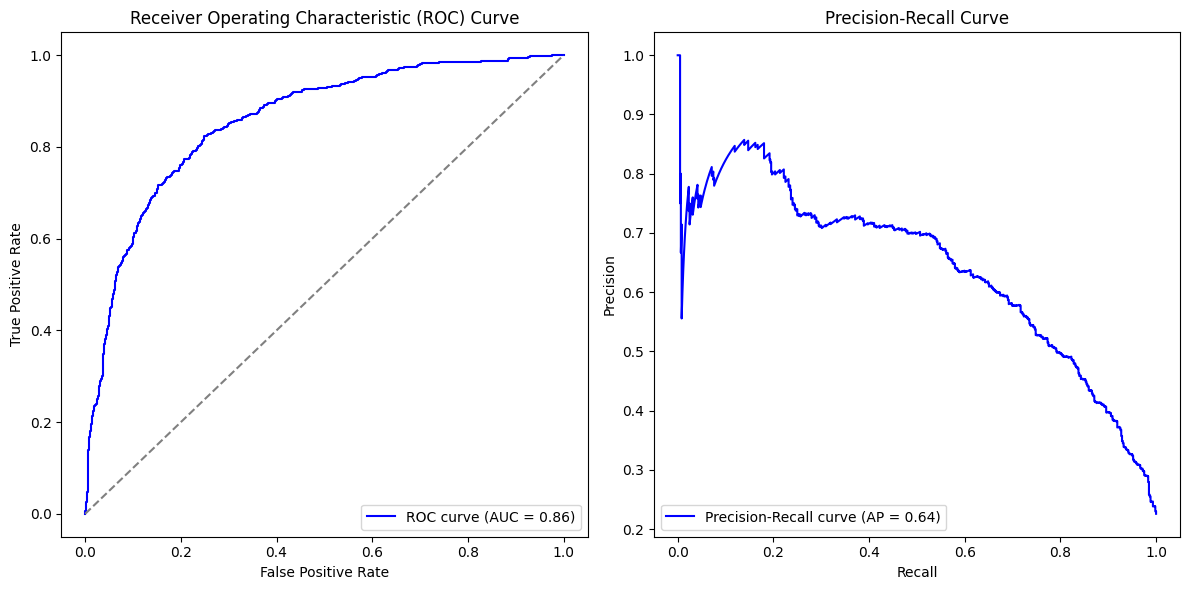

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


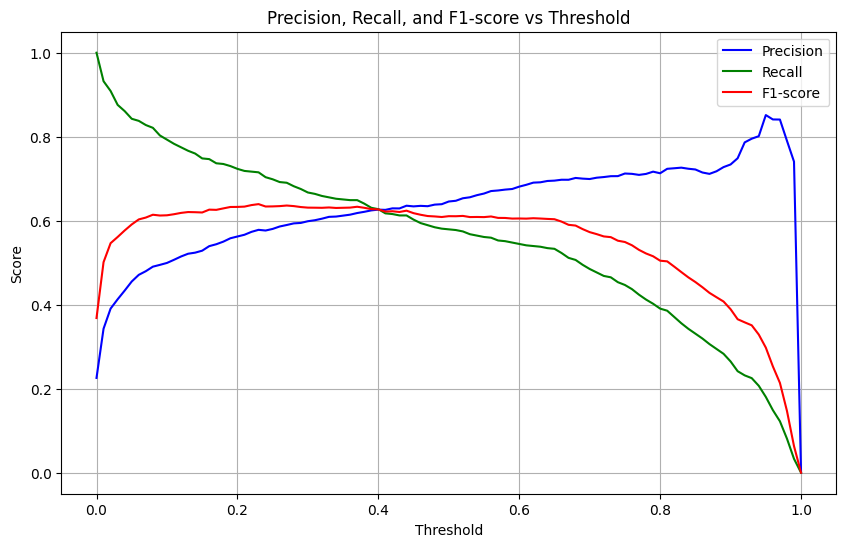

In [39]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = y_prob

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [40]:
from skfda.preprocessing.dim_reduction.variable_selection import RecursiveMaximaHunting

# Apply Recursive Maxima Hunting
rmh = RecursiveMaximaHunting(max_features=50)
rmh.fit(X_train_smooth, y=y_train)

# Get the selected points
selected_points = X_train_smooth.grid_points[0][rmh.get_support()]
print("Selected points:", selected_points)

Selected points: [0.12751678 0.29530201 0.30872483 0.32885906 0.34228188 0.3557047
 0.36912752 0.38255034 0.39597315 0.40939597 0.42281879 0.43624161
 0.44966443 0.46308725 0.47651007 0.4966443  0.61744966 0.96644295]


In [41]:
X_train_rmh = rmh.transform(X_train_smooth)
X_test_rmh = rmh.transform(X_test_smooth)
X_val_rmh = rmh.transform(X_val_smooth)

In [223]:
X_val_rmh.shape

(2676, 26)

In [42]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 1. Instantiate the classifier with some reasonable defaults
xgb_clf = xgb.XGBClassifier(
   # L2 regularization
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss', # or 'auc'
    n_estimators=200

)

# 2. Fit with early stopping on the validation set
xgb_clf.fit(
    X_train_rmh, y_train,
    eval_set=[(X_val_rmh, y_val)],
    verbose=True
)

# 3. Predictions on test set
y_pred = xgb_clf.predict(X_test_rmh)
y_prob = xgb_clf.predict_proba(X_test_rmh)[:,1]

# 4. Evaluation
acc  = accuracy_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)
print(f"Test Accuracy: {acc:.4f}")
print(f"Test AUC:      {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))




[0]	validation_0-logloss:0.45245
[1]	validation_0-logloss:0.42333


[2]	validation_0-logloss:0.40770
[3]	validation_0-logloss:0.39702
[4]	validation_0-logloss:0.39086
[5]	validation_0-logloss:0.38708
[6]	validation_0-logloss:0.38525
[7]	validation_0-logloss:0.38274
[8]	validation_0-logloss:0.38225
[9]	validation_0-logloss:0.38227
[10]	validation_0-logloss:0.38204
[11]	validation_0-logloss:0.38172
[12]	validation_0-logloss:0.38071
[13]	validation_0-logloss:0.38062
[14]	validation_0-logloss:0.38068
[15]	validation_0-logloss:0.37966
[16]	validation_0-logloss:0.37956
[17]	validation_0-logloss:0.37946
[18]	validation_0-logloss:0.38006
[19]	validation_0-logloss:0.38085
[20]	validation_0-logloss:0.37999
[21]	validation_0-logloss:0.37963
[22]	validation_0-logloss:0.38002
[23]	validation_0-logloss:0.37962
[24]	validation_0-logloss:0.37974
[25]	validation_0-logloss:0.38006
[26]	validation_0-logloss:0.37917
[27]	validation_0-logloss:0.37938
[28]	validation_0-logloss:0.37925
[29]	validation_0-logloss:0.37915
[30]	validation_0-logloss:0.37954
[31]	validation_0-logl

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:30:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[39]	validation_0-logloss:0.38345
[40]	validation_0-logloss:0.38425
[41]	validation_0-logloss:0.38413
[42]	validation_0-logloss:0.38424
[43]	validation_0-logloss:0.38479
[44]	validation_0-logloss:0.38387
[45]	validation_0-logloss:0.38391
[46]	validation_0-logloss:0.38358
[47]	validation_0-logloss:0.38405
[48]	validation_0-logloss:0.38490
[49]	validation_0-logloss:0.38484
[50]	validation_0-logloss:0.38498
[51]	validation_0-logloss:0.38451
[52]	validation_0-logloss:0.38498
[53]	validation_0-logloss:0.38565
[54]	validation_0-logloss:0.38583
[55]	validation_0-logloss:0.38642
[56]	validation_0-logloss:0.38737
[57]	validation_0-logloss:0.38845
[58]	validation_0-logloss:0.38913
[59]	validation_0-logloss:0.38974
[60]	validation_0-logloss:0.38994
[61]	validation_0-logloss:0.39052
[62]	validation_0-logloss:0.39119
[63]	validation_0-logloss:0.39176
[64]	validation_0-logloss:0.39232
[65]	validation_0-logloss:0.39262
[66]	validation_0-logloss:0.39285
[67]	validation_0-logloss:0.39315
[68]	validatio

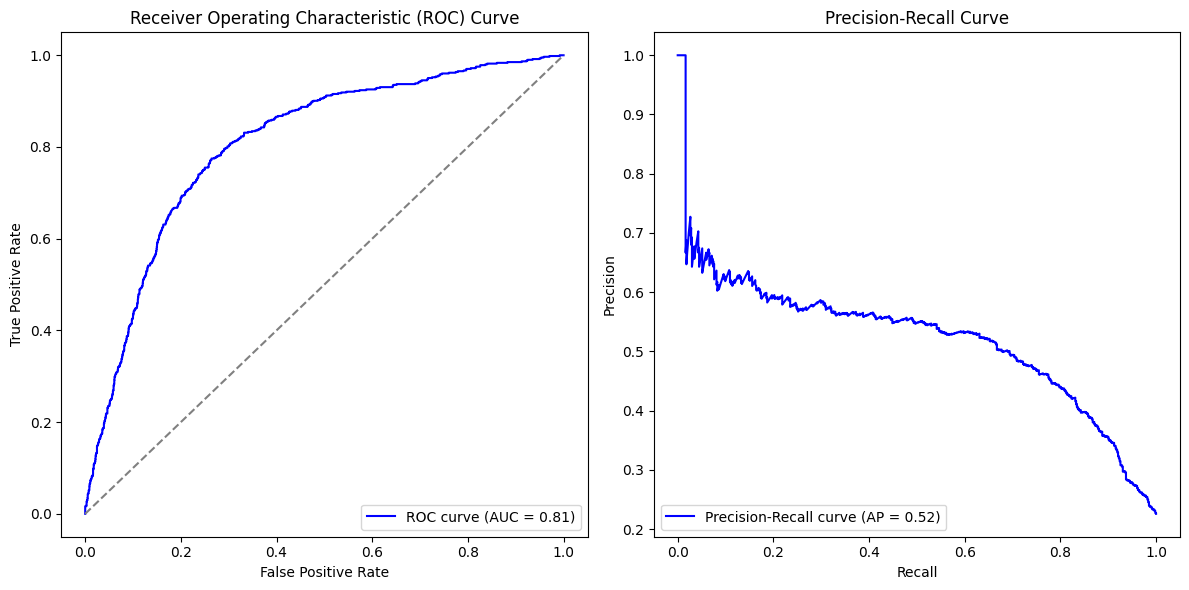

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

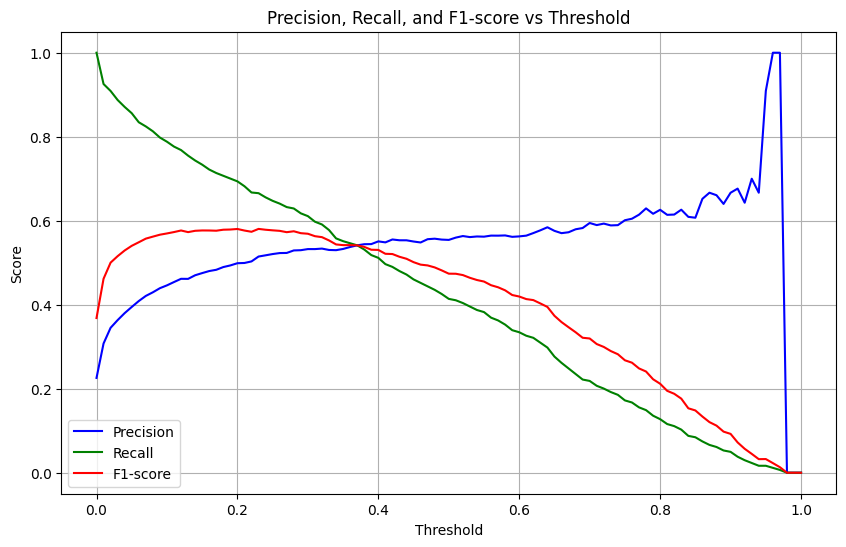

In [43]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = y_prob

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Define the neural network model
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_rmh.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),  # Dropout layer for regularization
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

print(model.summary())

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    X_train_rmh, y_train,
    epochs=25,
    batch_size=16,
    validation_data=(X_val_rmh, y_val),
    class_weight=class_weight_dict,  # ✅ Apply class weights here
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_rmh, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")


c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6739 - loss: 0.5600 - val_accuracy: 0.7664 - val_loss: 0.4954
Epoch 2/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7230 - loss: 0.5382 - val_accuracy: 0.7403 - val_loss: 0.5386
Epoch 3/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7233 - loss: 0.5151 - val_accuracy: 0.7500 - val_loss: 0.4880
Epoch 4/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7397 - loss: 0.5085 - val_accuracy: 0.7463 - val_loss: 0.5339
Epoch 5/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7400 - loss: 0.5147 - val_accuracy: 0.7433 - val_loss: 0.5010
Epoch 6/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7330 - loss: 0.5293 - val_accuracy: 0.7504 - val_loss: 0.5238
Epoch 7/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7496 - loss: 0.5152 - val_accuracy: 0.7399 - val_loss: 0.5251
Epoch 8/25
502/502 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7515 - loss: 0.4945 - val_accurac

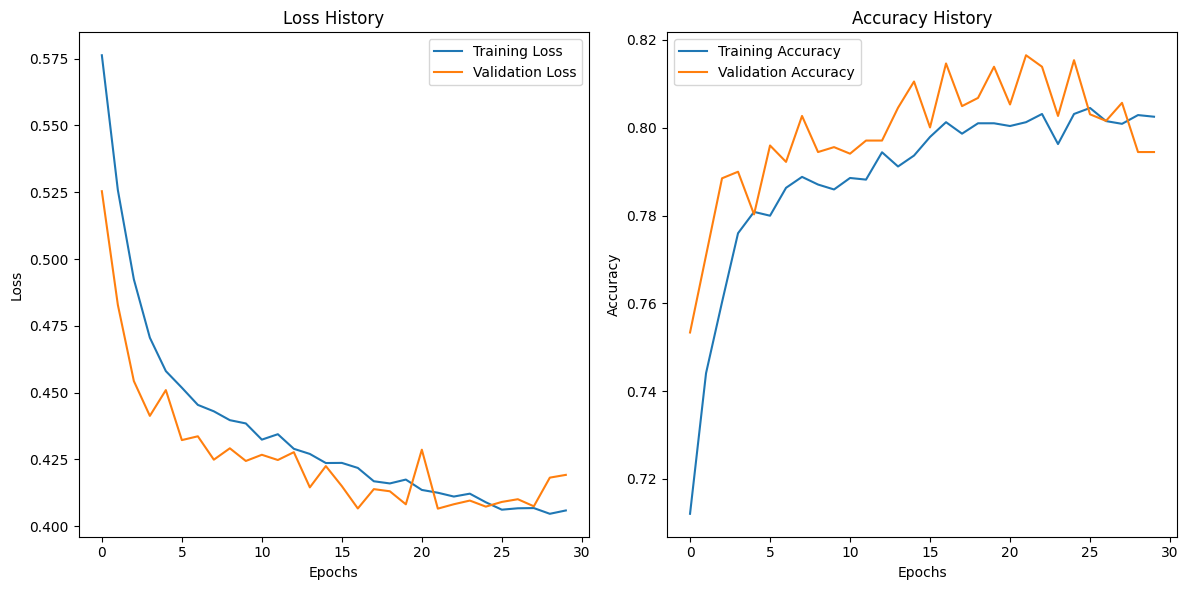

In [203]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy History')
plt.legend()

plt.tight_layout()
plt.show()

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


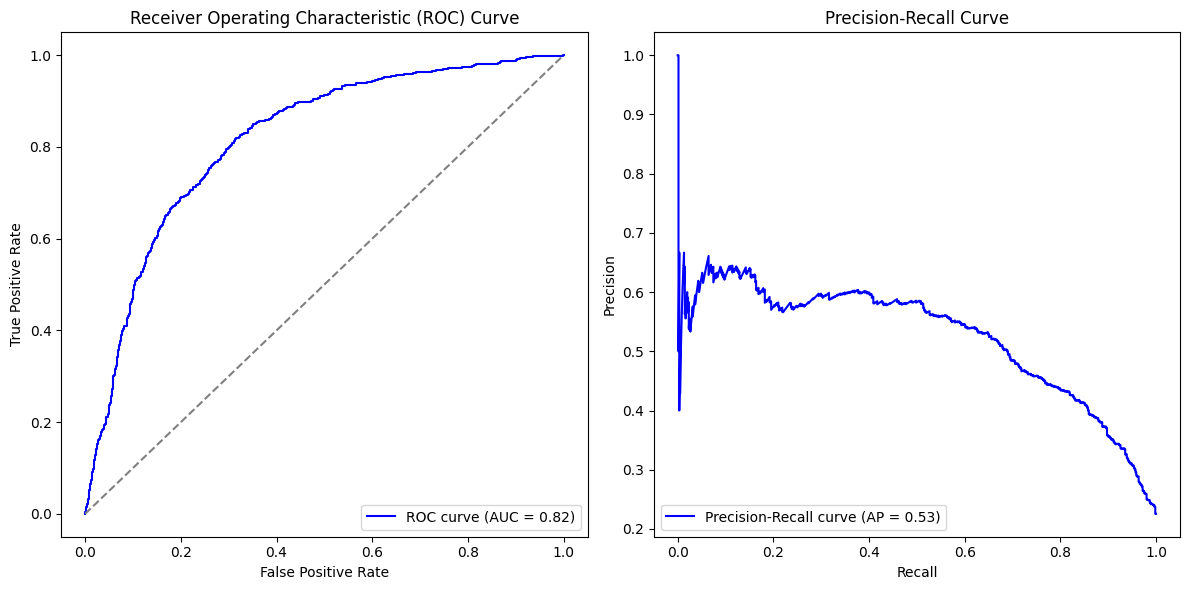

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

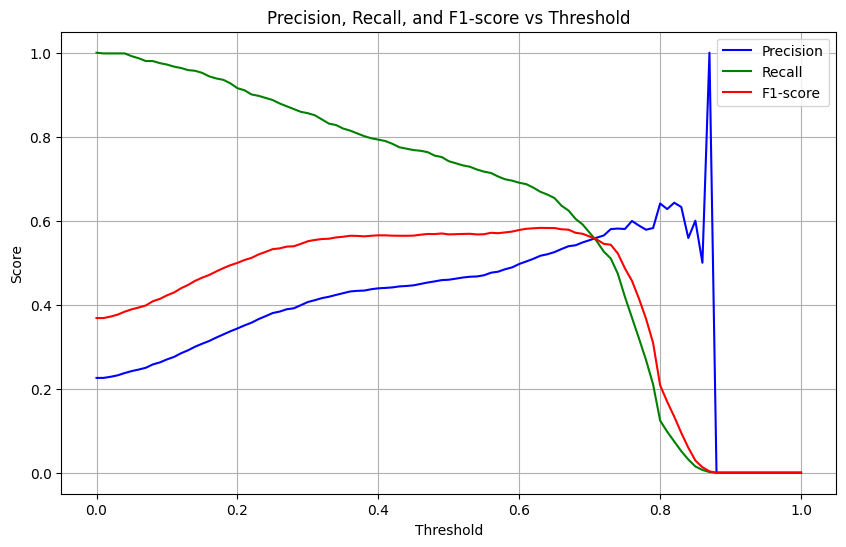

In [45]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test_rmh)

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [71]:



# Define the neural network model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_smooth.data_matrix.shape[1],)),
    layers.Dropout(0.1),  # Dropout layer for regularization
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

print(model.summary())

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_smooth.data_matrix, y_train, epochs=10, batch_size=32, validation_data=(X_val_smooth.data_matrix, y_val), verbose=1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_smooth.data_matrix, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 64)             │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7636 - loss: 0.4999 - val_accuracy: 0.7900 - val_loss: 0.4193
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7987 - loss: 0.4175 - val_accuracy: 0.8188 - val_loss: 0.3918
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8015 - loss: 0.4007 - val_accuracy: 0.8098 - val_loss: 0.3886
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8033 - loss: 0.4134 - val_accuracy: 0.8117 - val_loss: 0.3852
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8030 - loss: 0.3962 - val_accuracy: 0.8203 - val_loss: 0.3817
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7990 - loss: 0.4034 - val_accuracy: 0.8158 - val_loss: 0.3832
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8140 - loss: 0.3901 - val_accuracy: 0.8184 - val_loss: 0.3821
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8119 - loss: 0.3881 - val_accurac

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


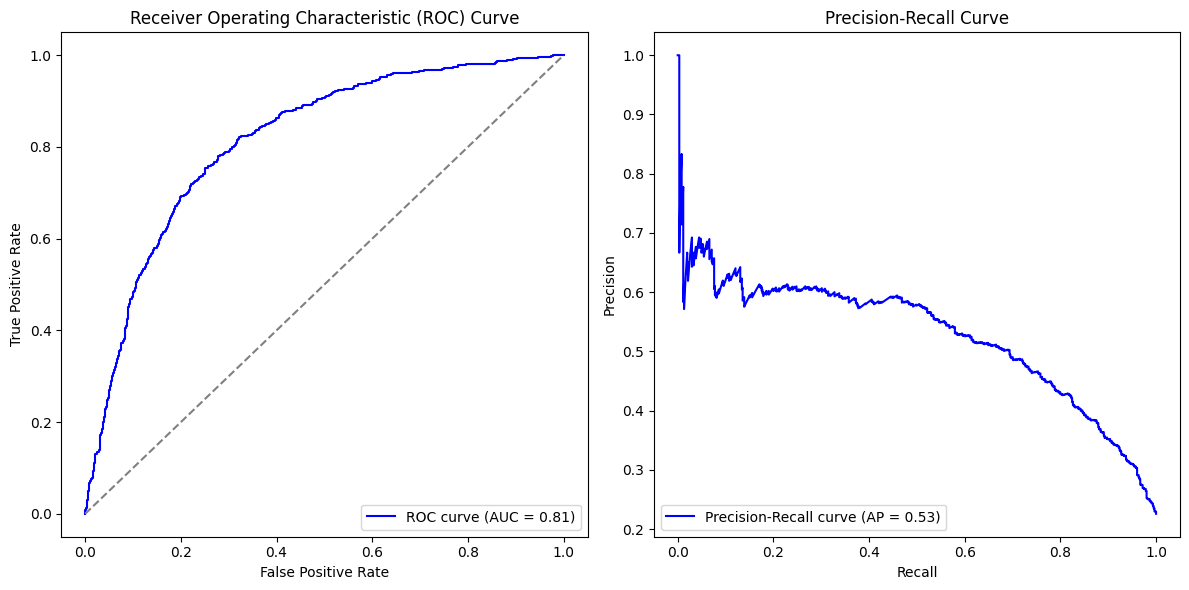

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

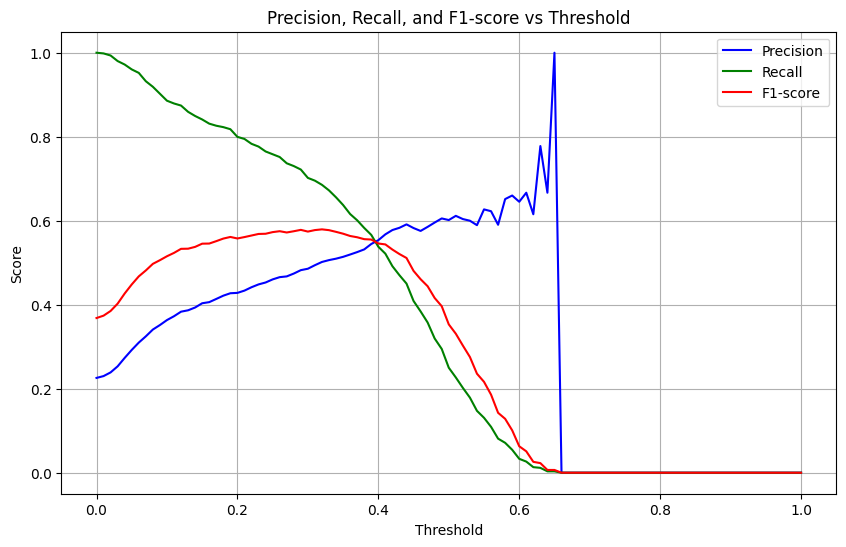

In [72]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test_smooth.data_matrix)

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [80]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
max_len = 150
# Define the inverse model
inverse_model = tf.keras.Sequential([
    layers.Input(shape=(max_len,)),  # Input shape matches the input to the classification model
    layers.Dense(64, activation='relu'),
    layers.Dense(max_len, activation='relu')  # Output shape matches the input shape
])
# Define a custom loss function to maximize the cheating probability
def custom_loss(y_true, y_pred):
    cheating_prob = model(y_pred, training=False)  # Get the cheating probability from the classification model
    # Also penalize the model for being close to zero, we want values that are far from zero
    return -tf.reduce_mean(cheating_prob)  # Negative log likelihood


# Compile the inverse model
inverse_model.compile(optimizer='adam', loss=custom_loss)



# Generate random initial input for the inverse model
initial_input = np.random.uniform(-15, 15, size=(1, max_len)).astype('float32')

# Train the inverse model
inverse_model.fit(
    x=initial_input,
    y=np.zeros_like(initial_input),  # Dummy target, as the loss is custom
    epochs=50,
    batch_size=1,
    verbose=1
)

# Get the "most cheating" game
most_cheating_game = inverse_model.predict(initial_input)
print("Most cheating game:", most_cheating_game)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step - loss: -0.0034
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: -0.0656
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: -0.2229
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: -0.5569
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: -0.7910
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: -0.8822
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: -0.9287
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: -0.9427
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: -0.9561
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: -0.9674
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: -0.9752
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: -0.9798
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: -0.9841
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: -0.9872
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: -0.9899
Epoch 16/50
1/1 ━━

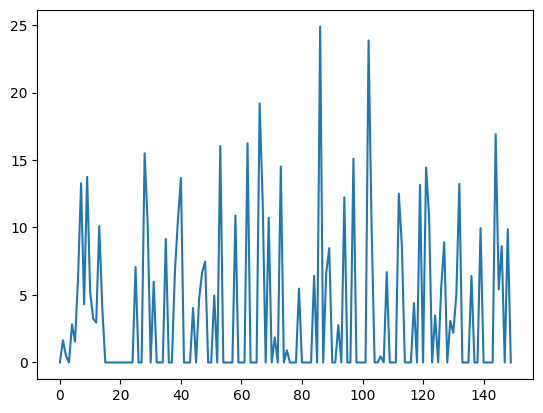

In [81]:
plt.plot(most_cheating_game[0])

In [48]:
selected_indices = rmh.get_support(indices=True)
rejected_indices = np.setdiff1d(np.arange(X_train_smooth.data_matrix.shape[1]), selected_indices)

In [49]:
# Replace values at the selected points with 42 in all smoothed datasets
X_train_rmh = skfda.FDataGrid(X_train_smooth.data_matrix.copy(), grid_points=X_train_smooth.grid_points)
X_val_rmh = skfda.FDataGrid(X_val_smooth.data_matrix.copy(), grid_points=X_val_smooth.grid_points)
X_test_rmh = skfda.FDataGrid(X_test_smooth.data_matrix.copy(), grid_points=X_test_smooth.grid_points)
for dataset in [X_train_rmh, X_val_rmh, X_test_rmh]:
    dataset.data_matrix[..., rejected_indices, :] = 42

In [55]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Supón que ya tienes dos listas:
#   evals: lista de listas de floats con las evaluaciones por movimiento
#   cheating: lista de ceros y unos indicadoras de si blancas hicieron trampa

# Parámetros
max_len = 150  # longitud máxima de secuencia
batch_size = 32
epochs = 10


# Definir el modelo
model = Sequential([
    Masking(mask_value=42, input_shape=(max_len, 1)),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Ver resumen
model.summary()

# Entrenar con conjunto de validación
history = model.fit(
    X_train_rmh.data_matrix, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_rmh.data_matrix, y_val)
)

# Evaluar en Test
test_loss, test_acc = model.evaluate(X_test_rmh.data_matrix, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Guardar modelo si lo deseas
# model.save('lstm_cheating_detector.h5')


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 150, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.7606 - loss: 0.6398 - val_accuracy: 0.7896 - val_loss: 0.4103
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7937 - loss: 0.4218 - val_accuracy: 0.7896 - val_loss: 0.4085
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7786 - loss: 0.4274 - val_accuracy: 0.7896 - val_loss: 0.4069
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7979 - loss: 0.4086 - val_accuracy: 0.7960 - val_loss: 0.4064
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.7861 - loss: 0.4181 - val_accuracy: 0.7967 - val_loss: 0.4055
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7978 - loss: 0.4247 - val_accuracy: 0.8019 - val_loss: 0.4037
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7942 - loss: 0.4211 - val_accuracy: 0.8023 - val_loss: 0.4026
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7962 - loss: 0.4087 - 

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


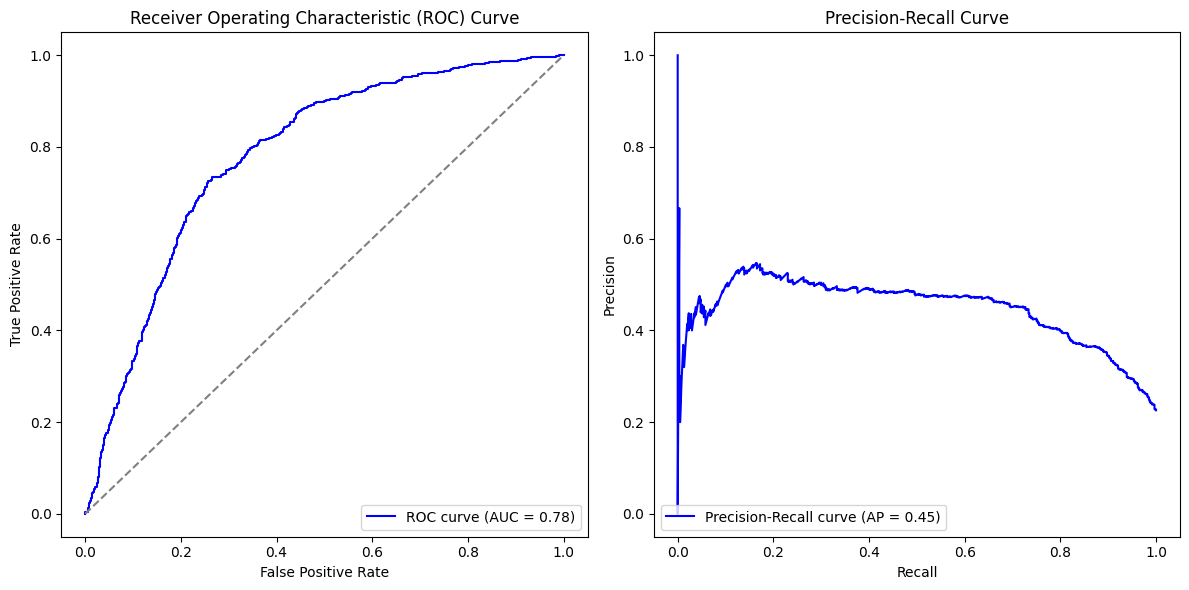

c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yoyom\OneDrive\Escritorio\AE\Programacion\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

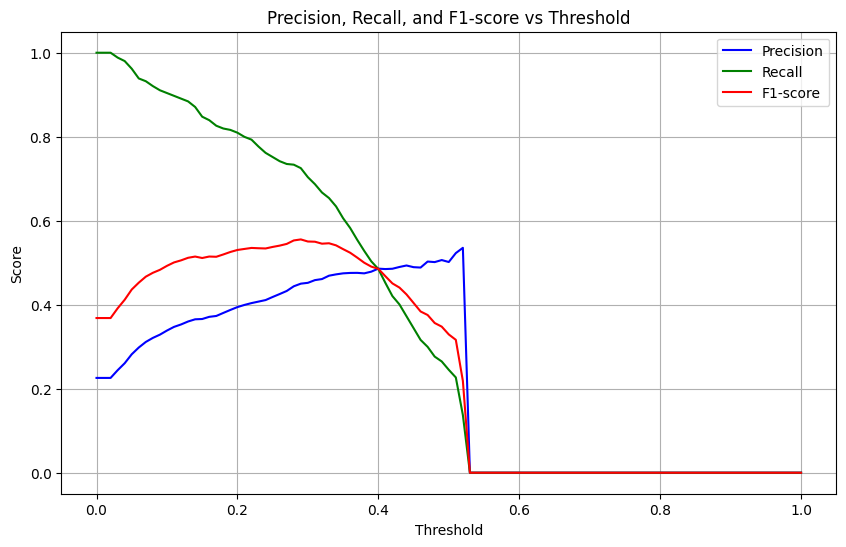

In [56]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Obtener las probabilidades de predicción del modelo en el conjunto de prueba
y_pred_prob = model.predict(X_test_rmh.data_matrix)

# Calcular la curva ROC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calcular la curva de Precisión-Recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Graficar la Curva ROC
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Graficar la Curva de Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


from sklearn.metrics import precision_score, recall_score, f1_score

# Umbrales a evaluar
thresholds_roc = np.linspace(0, 1, 101)

# Listas para almacenar los resultados
precisions = []
recalls = []
f1_scores = []

# Iterar sobre los diferentes umbrales
for threshold in thresholds_roc:
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calcular precision, recall y f1-score usando sklearn
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Guardar los valores
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Graficar las métricas en función del umbral
plt.figure(figsize=(10, 6))
plt.plot(thresholds_roc, precisions, color='blue', label='Precision')
plt.plot(thresholds_roc, recalls, color='green', label='Recall')
plt.plot(thresholds_roc, f1_scores, color='red', label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


To do: 

1- Hacer mejor descripcion (identificacion de outliers, buscar outliers por clase y tal)
2- Seleccionar modelos para comparación -> comparación de modelos mediante métricas